<a href="https://colab.research.google.com/github/Ayush770/image-quality-classifier/blob/main/Image_Quality_Classifier_with_Auto_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kwentar/blur-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'blur-dataset' dataset.
Path to dataset files: /kaggle/input/blur-dataset


In [ ]:
import os

# Path where the dataset was downloaded
dataset_path = "/kaggle/input/blur-dataset"

# Walk through the folders inside the dataset and print the structure
for root, dirs, files in os.walk(dataset_path):
    print(root, "->", dirs[:5], files[:5])


/kaggle/input/blur-dataset -> ['defocused_blurred', 'sharp', 'motion_blurred', 'blur_dataset_scaled'] []
/kaggle/input/blur-dataset/defocused_blurred -> [] ['0_IPHONE-SE_F.JPG', '330_XIAOMI-PROCOFONE-F1_F.jpg', '46_IPHONE-8-PLUS_F.jpg', '121_HONOR-7X_F.jpg', '337_XIAOMI-PROCOFONE-F1_F.jpg']
/kaggle/input/blur-dataset/sharp -> [] ['186_HONOR-8_S.jpg', '125_NIKON-D3400-35MM_S.JPG', '155_HONOR-10_S.jpg', '299_NIKON-D3400-35MM_S.JPG', '32_HUAWEI-P-SMART_S.jpg']
/kaggle/input/blur-dataset/motion_blurred -> [] ['191_NIKON-D3400-18-55MM_M.JPG', '343_XIAOMI-PROCOFONE-F1_M.jpg', '278_HONOR-7X_M.jpg', '54_HONOR-8X_M.jpg', '60_IPHONE-8-PLUS_M.jpg']
/kaggle/input/blur-dataset/blur_dataset_scaled -> ['defocused_blurred', 'sharp', 'motion_blurred'] []
/kaggle/input/blur-dataset/blur_dataset_scaled/defocused_blurred -> [] ['0_IPHONE-SE_F.JPG', '330_XIAOMI-PROCOFONE-F1_F.jpg', '46_IPHONE-8-PLUS_F.jpg', '121_HONOR-7X_F.jpg', '337_XIAOMI-PROCOFONE-F1_F.jpg']
/kaggle/input/blur-dataset/blur_dataset_scale

In [ ]:
import os

SRC = "/kaggle/input/blur-dataset/blur_dataset_scaled"
print(os.listdir(SRC))

['defocused_blurred', 'sharp', 'motion_blurred']


In [ ]:
import os, shutil, pathlib

SRC = "/kaggle/input/blur-dataset/blur_dataset_scaled"  # use the scaled set
DST = "/content/blur_bin"  # writable location

# Start clean
if os.path.exists(DST):
    shutil.rmtree(DST)
os.makedirs(DST, exist_ok=True)

# Create target folders
os.makedirs(f"{DST}/blurred", exist_ok=True)
os.makedirs(f"{DST}/sharp", exist_ok=True)

# Helper to bulk copy files
def copy_all(src_dir, dst_dir):
    for fn in os.listdir(src_dir):
        s = os.path.join(src_dir, fn)
        if os.path.isfile(s):
            shutil.copy2(s, dst_dir)

# Merge both blur types into one "blurred" class
copy_all(f"{SRC}/defocused_blurred", f"{DST}/blurred")
copy_all(f"{SRC}/motion_blurred",   f"{DST}/blurred")
# Copy sharp as-is
copy_all(f"{SRC}/sharp",            f"{DST}/sharp")

print("Binary dataset ready at:", DST)
print("blurred:", len(os.listdir(f'{DST}/blurred')), "sharp:", len(os.listdir(f'{DST}/sharp')))


Binary dataset ready at: /content/blur_bin
blurred: 700 sharp: 350


In [ ]:
import tensorflow as tf
from tensorflow import keras

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/blur_bin",
    validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/blur_bin",
    validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

print("Classes:", train_ds.class_names)  # ['blurred', 'sharp']

Found 1050 files belonging to 2 classes.
Using 840 files for training.
Found 1050 files belonging to 2 classes.
Using 210 files for validation.
Classes: ['blurred', 'sharp']


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.1),
], name="augment")

base = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)
base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = augment(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  # binary
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC(name="auc")])

history = model.fit(train_ds, validation_data=val_ds, epochs=12)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5941 - auc: 0.5699 - loss: 0.7476 - val_accuracy: 0.6762 - val_auc: 0.6765 - val_loss: 0.6274
Epoch 2/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7484 - auc: 0.7820 - loss: 0.5075 - val_accuracy: 0.7095 - val_auc: 0.8023 - val_loss: 0.5324
Epoch 3/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8103 - auc: 0.8634 - loss: 0.4410 - val_accuracy: 0.7286 - val_auc: 0.8482 - val_loss: 0.5099
Epoch 4/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8144 - auc: 0.8838 - loss: 0.3997 - val_accuracy: 0.7333 - val_auc: 0.8661 - val_loss: 0.4897
Epoch 5/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8585 - auc: 0.9234 - loss: 0.3408 - val_accuracy: 0.7952 - val_auc: 0.8807 - val_loss: 0.4301
Epoch 6/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8661 - auc: 0.9290 - loss: 0.3319 - val_accuracy: 0.8190 - val_auc: 0.8966 - val_loss: 0.4107
Epo

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = (224, 224)

# 1) Grab the trained base backbone from your current model
#    Find the MobileNetV2 layer in your model by type or name.
base_backbone = None
for L in model.layers:
    if isinstance(L, keras.Model) and "MobilenetV2" in L.name.lower():
        base_backbone = L
        break
# Fallback: many times the base is directly accessible via variable `base`
if base_backbone is None:
    base_backbone = base  # if you still have `base` from earlier

base_backbone.trainable = False

# 2) Rebuild a minimal inference graph: preprocess -> base -> GAP -> Dense(sigmoid)
inp = keras.Input(shape=IMG_SIZE + (3,), name="image")
x = keras.applications.mobilenet_v2.preprocess_input(inp)
x = base_backbone(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
out = layers.Dense(1, activation="sigmoid", name="pred")(x)
inference_model = keras.Model(inp, out, name="iqc_inference")

In [ ]:
# Last Dense layer is the only one with weights we need to copy
inference_model.layers[-1].set_weights(model.layers[-1].get_weights())

In [ ]:
print(inference_model.summary())

Model: "iqc_inference"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
with open("/content/iqc_model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ TFLite saved to /content/iqc_model.tflite")

Saved artifact at '/tmp/tmp8q6t1dat'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137497025512848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025516304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025516496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025514576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025515536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025516688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025517840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025518032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025516880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025515728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137497025516112: Tens

In [ ]:
import numpy as np
from PIL import Image

loaded = inference_model  # or tf.keras.models.load_model("/content/iqc_model.keras")

def predict_image(path):
    img = Image.open(path).convert("RGB").resize(IMG_SIZE)
    x = np.asarray(img, dtype=np.float32)[None, ...]
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    prob_sharp = float(loaded.predict(x, verbose=0).ravel()[0])
    label = "sharp" if prob_sharp > 0.5 else "blurred"
    conf  = prob_sharp if label == "sharp" else 1.0 - prob_sharp
    return {"label": label, "confidence": round(conf, 4)}

Image: 205_HUAWEI-P20-LITE_F.jpg


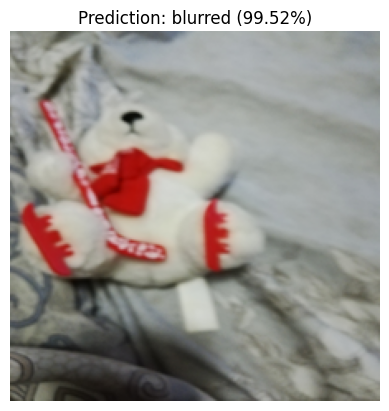

Image: 339_XIAOMI-REDMI-4X_F.jpg


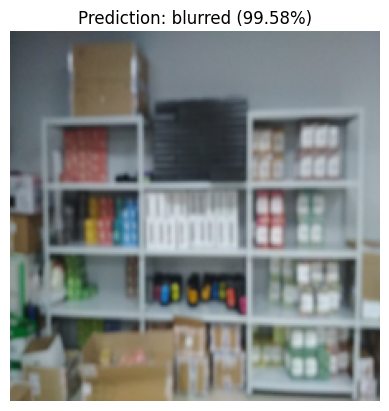

Image: 8_SAMSUNG-GALAXY-A6_F.jpg


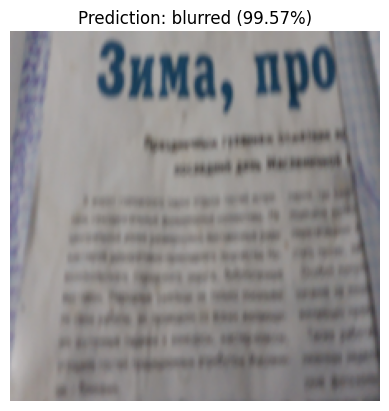

Image: 102_NIKON-D3400-35MM_F.JPG


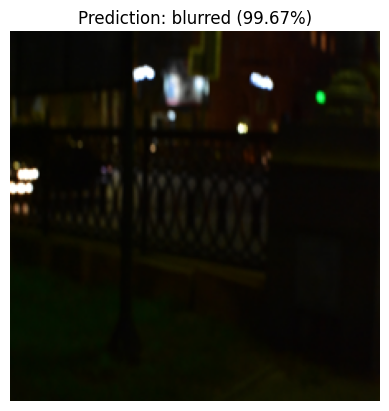

Image: 282_SONY-NEX-5T_F.JPG


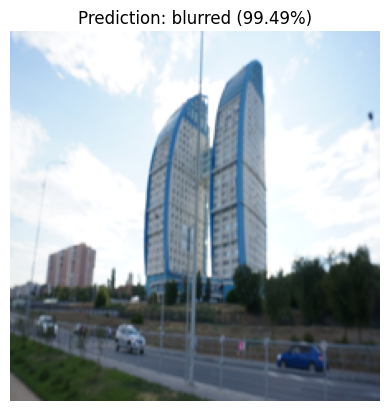

Image: 168_CANON-6D-100MM_F.JPG


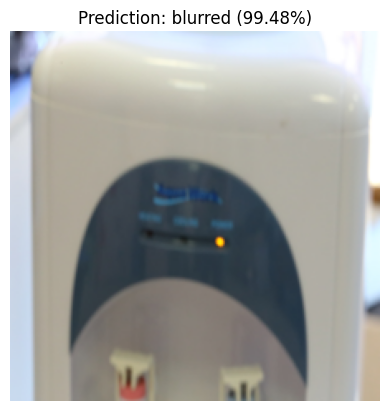

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob, os

# Change this if needed
IMG_SIZE = (224, 224)

# If you haven't already:
loaded = inference_model   # or load again if needed

# Pick a few sample images
sample_images = glob.glob("/content/blur_bin/*/*.jpg")[:3] \
               + glob.glob("/content/blur_bin/*/*.JPG")[:3]

def show_prediction(img_path):
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    x = np.array(img, dtype="float32")[None, ...]
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    prob_sharp = float(loaded.predict(x, verbose=0).ravel()[0])
    label = "sharp" if prob_sharp > 0.5 else "blurred"
    confidence = prob_sharp if label == "sharp" else 1.0 - prob_sharp

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
    plt.show()

# Show predictions
for img in sample_images[:20]:
    print("Image:", os.path.basename(img))
    show_prediction(img)


Found 1050 files belonging to 2 classes.
CLASS_NAMES: ['blurred', 'sharp']
Found images: 1050
Scored images: 1050
No sharp images after filtering—showing top overall by prob_sharp instead.
Showing top 5 most confidently SHARP images:


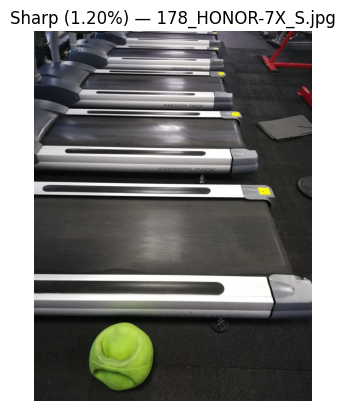

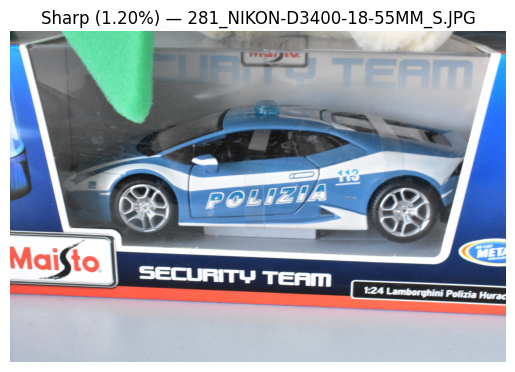

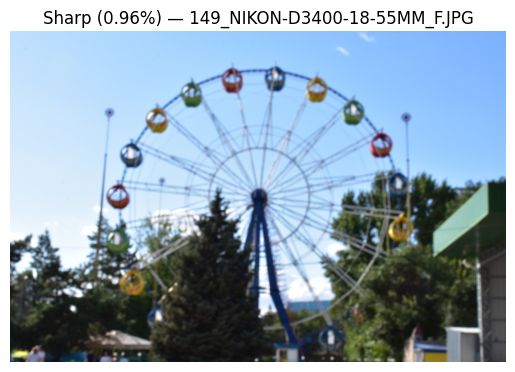

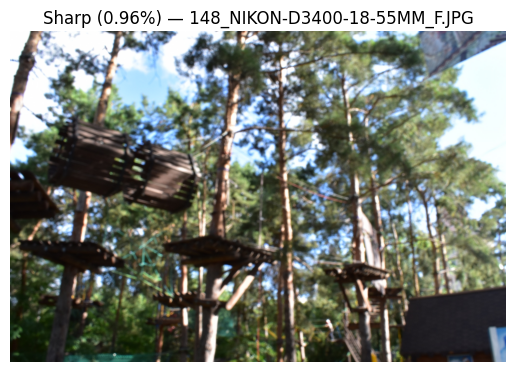

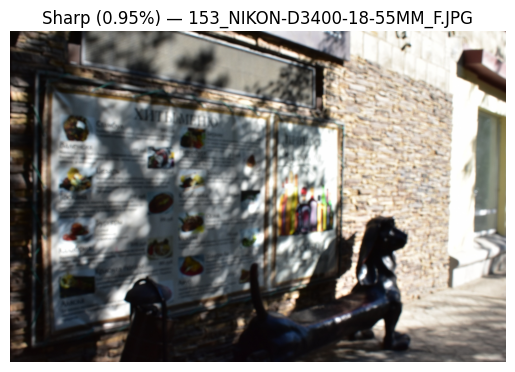

In [ ]:
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = (224, 224)
DATA_DIR = "/content/blur_bin"  # your binary dataset

# --- 1) Recreate a tiny dataset JUST to get class_names (no prefetch) ---
_tmp = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=1, shuffle=False
)
CLASS_NAMES = _tmp.class_names  # e.g. ['blurred','sharp'] (alphabetical)
print("CLASS_NAMES:", CLASS_NAMES)

# With Dense(1, sigmoid), model.predict returns probability of class index 1.
index_one_class = CLASS_NAMES[1]  # e.g. 'sharp' if ['blurred','sharp']

# --- 2) Load your inference model (or SavedModel) ---
try:
    loaded = inference_model
except NameError:
    loaded = tf.keras.models.load_model("/content/iqc_savedmodel")

def prob_sharp_from_prob_one(prob_one: float) -> float:
    """Map sigmoid output (prob of class index 1) to probability of 'sharp'."""
    if index_one_class.lower() == "sharp":
        return prob_one
    else:
        return 1.0 - prob_one  # index 1 is 'blurred', so invert

def predict_prob_sharp(img_path: str) -> float:
    img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
    x = np.asarray(img, dtype=np.float32)[None, ...]
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    prob_one = float(loaded.predict(x, verbose=0).ravel()[0])  # prob(class index 1)
    return prob_sharp_from_prob_one(prob_one)

# --- 3) Gather files robustly ---
patterns = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
all_images = []
for p in patterns:
    all_images += glob.glob(os.path.join(DATA_DIR, "*", p))
print("Found images:", len(all_images))

# --- 4) Score and show top-N sharp images ---
results = []
for p in all_images:
    try:
        ps = predict_prob_sharp(p)
        results.append((p, ps))
    except Exception:
        pass

print("Scored images:", len(results))

# Keep >0.5 as sharp, sort by confidence desc
sharp_results = [(p, c) for (p, c) in results if c > 0.5]
sharp_results.sort(key=lambda x: x[1], reverse=True)

if not sharp_results:
    print("No sharp images after filtering—showing top overall by prob_sharp instead.")
    sharp_results = sorted(results, key=lambda x: x[1], reverse=True)

N = 5
print(f"Showing top {N} most confidently SHARP images:")
for img_path, conf in sharp_results[:N]:
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Sharp ({conf*100:.2f}%) — {os.path.basename(img_path)}")
    plt.show()


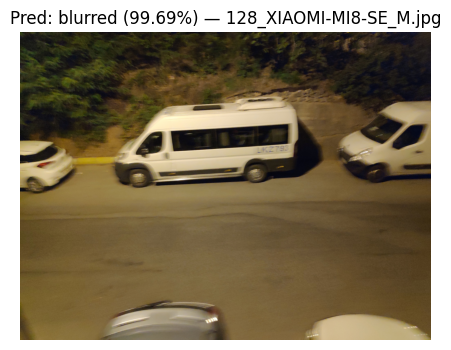

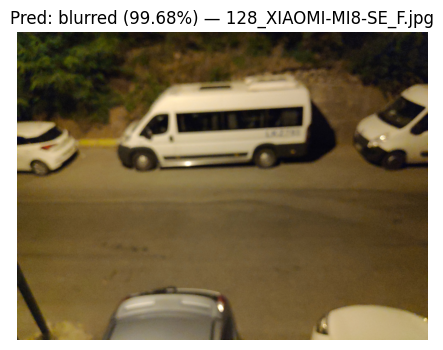

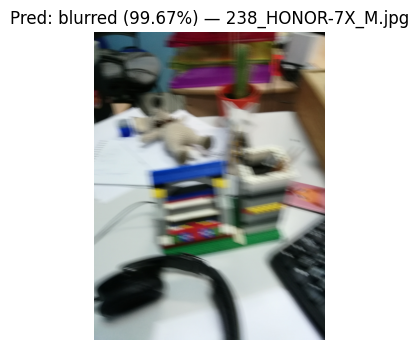

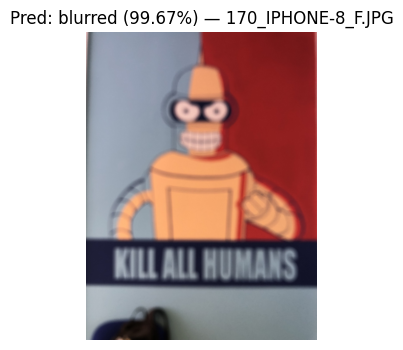

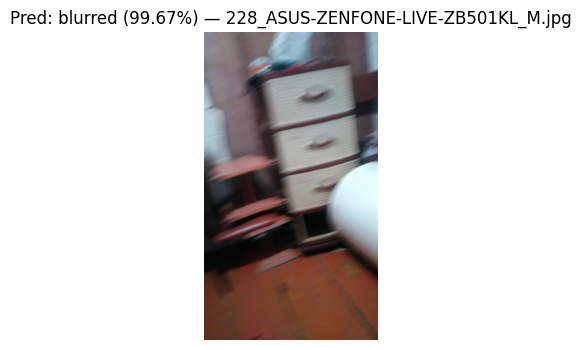

In [ ]:
# most confidently BLURRY among true blurred
blur_files = []
for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"):
    blur_files += glob.glob(os.path.join(DATA_DIR, "blurred", ext))

scored_blur = []
for p in blur_files:
    ps = predict_prob_sharp(p)
    scored_blur.append((p, 1.0 - ps))  # confidence of BLURRY

scored_blur.sort(key=lambda x: x[1], reverse=True)
for img_path, conf in scored_blur[:5]:
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: blurred ({conf*100:.2f}%) — {os.path.basename(img_path)}")
    plt.show()


In [ ]:
# --- Step 1: Configure your Git identity (optional but good practice)
!git config --global user.email "triveday7@gmail.com"
!git config --global user.name "Ayush770"

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# --- Step 2: Define repository variables
USER = "Ayush770"                   # Your GitHub username
REPO = "image-quality-classifier"    # Your repository name
URL = f"https://github.com/{USER}/{REPO}.git"

print("Using repo:", URL)

Using repo: https://github.com/Ayush770/image-quality-classifier.git


In [ ]:
!git clone "https://github.com/Ayush770/image-quality-classifier.git"

fatal: destination path 'image-quality-classifier' already exists and is not an empty directory.
